In [41]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import xgboost as xgb


In [2]:
FILE_PATH = os.path.join(os.getcwd() ,'all.Xlsx')
df = pd.read_excel(FILE_PATH)
df

,Number,Hgb,Gender,Age
0,1,9.3,F,82
1,2,10.2,F,77
2,3,10.7,F,52
3,4,11.7,F,73
4,5,11.6,F,74
...,...,...,...,...
213,214,13.4,M,21
214,215,13.7,F,55
215,216,12.7,M,29
216,217,11.1,F,53


In [3]:
#0 = f , 1 = m
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['Gender'])
df=df.drop(columns=['Gender'])
df

,Number,Hgb,Age,gender
0,1,9.3,82,0
1,2,10.2,77,0
2,3,10.7,52,0
3,4,11.7,73,0
4,5,11.6,74,0
...,...,...,...,...
213,214,13.4,21,1
214,215,13.7,55,0
215,216,12.7,29,1
216,217,11.1,53,0


In [4]:
df.isna().sum()

Number    0
Hgb       1
Age       0
gender    0
dtype: int64

In [5]:
df=df.dropna()

In [6]:
df.isna().sum()

Number    0
Hgb       0
Age       0
gender    0
dtype: int64

In [7]:
#remord number 93 since it doesn't contain hemoglobin level ,, we will not upload the photo to the model also
df[df['Number'] ==93]

,Number,Hgb,Age,gender


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 0 to 217
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Number  217 non-null    int64  
 1   Hgb     217 non-null    float64
 2   Age     217 non-null    int64  
 3   gender  217 non-null    int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 7.6 KB


In [9]:
df.describe()

,Number,Hgb,Age,gender
count,217.000000,217.000000,217.000000,217.000000
mean,109.576037,12.797097,42.433180,0.603687
std,63.211176,2.362605,16.757707,0.490262
min,1.000000,7.000000,19.000000,0.000000
25%,55.000000,11.000000,29.000000,0.000000
50%,110.000000,13.200000,40.000000,1.000000
75%,164.000000,14.900000,54.000000,1.000000
max,218.000000,17.400000,88.000000,1.000000


In [10]:
df['Hgb'].describe()

count    217.000000
mean      12.797097
std        2.362605
min        7.000000
25%       11.000000
50%       13.200000
75%       14.900000
max       17.400000
Name: Hgb, dtype: float64

In [11]:
scatter_fig = px.scatter(
    df, 
    x='Age', 
    y='Hgb', 
    color='gender',
    title='Scatter Plot: Age vs. Hemoglobin (Hgb)',
    labels={'Age': 'Age', 'Hgb': 'Hemoglobin (Hgb)'}
)
scatter_fig.show()


In [12]:
histogram_fig = px.histogram(
    df, 
    x='Hgb', 
    nbins=10, 
    title='Histogram: Distribution of Hemoglobin (Hgb)',
    labels={'Hgb': 'Hemoglobin (Hgb)'}
)
histogram_fig.show()

In [13]:
box_fig = px.box(
    df, 
    x='gender', 
    y='Hgb', 
    title='Box Plot: Hemoglobin (Hgb) by Gender',
    labels={'Hgb': 'Hemoglobin (Hgb)'}
)
box_fig.show()

In [14]:
df[df['Hgb'] >= 12].count() 

Number    141
Hgb       141
Age       141
gender    141
dtype: int64

In [15]:
df[df['Hgb'] < 12].count() 

Number    76
Hgb       76
Age       76
gender    76
dtype: int64

In [16]:
df

,Number,Hgb,Age,gender
0,1,9.3,82,0
1,2,10.2,77,0
2,3,10.7,52,0
3,4,11.7,73,0
4,5,11.6,74,0
...,...,...,...,...
213,214,13.4,21,1
214,215,13.7,55,0
215,216,12.7,29,1
216,217,11.1,53,0


In [17]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications.densenet import preprocess_input

# Function to preprocess an image for DenseNet
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32)
    img = preprocess_input(img)  # Apply DenseNet preprocessing
    return img

def load_images_and_metadata(base_folder, df, target_size=(224, 224)):
    images, metadata, labels = [], [], []
    
    # Iterate over each row in the dataframe
    for i, row in df.iterrows():
        folder_number = str(int(row['Number']))  # Convert 'Number' to integer and then to string
        folder_path = os.path.join(base_folder, folder_number)
        
        # Check if the folder exists for the current 'Number'
        if os.path.exists(folder_path):
            # Loop through all files in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if os.path.isfile(file_path):  # Ensure it's a file
                    try:
                        # Preprocess the image
                        img = preprocess_image(file_path, target_size)
                        images.append(img)
                        
                        # Append the metadata and labels (linked by folder 'Number')
                        metadata_features = [row['Age'], row['gender']]
                        metadata.append(metadata_features)
                        labels.append(row['Hgb'])
                    except Exception as e:
                        print(f"Error processing image {file_path}: {e}")
        else:
            print(f"Warning: Folder {folder_number} does not exist. Skipping.")
    
    return np.array(images), np.array(metadata), np.array(labels)

# Set the base folder where images are stored
base_folder = "D:/Me/grad/dataset anemia (1)/dataset anemia/Final_Data"

# Example: Assuming your dataframe 'df' is loaded and contains the necessary metadata
# Columns in df: ['Number', 'Age', 'gender', 'Age_Group', 'Hgb']
images, metadata, labels = load_images_and_metadata(base_folder, df)

print("Images shape:", images.shape)  
print("Metadata shape:", metadata.shape)  
print("Labels shape:", labels.shape)


Images shape: (217, 224, 224, 3)
Metadata shape: (217, 2)
Labels shape: (217,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


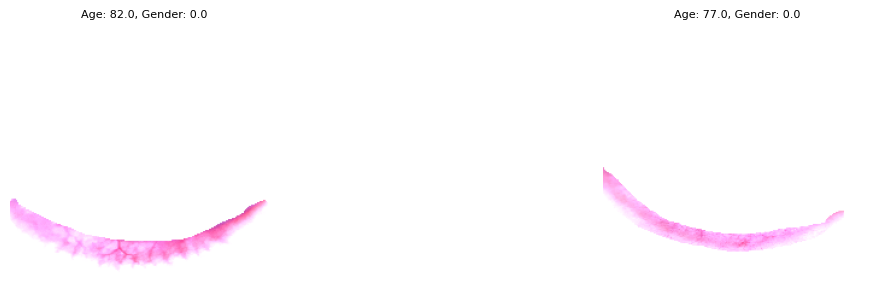

In [18]:
import matplotlib.pyplot as plt

# Function to visualize images with metadata
def visualize_images(images, metadata, num_samples=2):
    # Number of images to display from the start and end
    start_images = images[:num_samples]
    end_images = images[-num_samples:]

    start_metadata = metadata[:num_samples]

    all_images = list(start_images) + list(end_images)
    all_metadata = list(start_metadata) 

    plt.figure(figsize=(12, 6))

    for i, (img, meta) in enumerate(zip(all_images, all_metadata)):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow((img + 1) / 2)  # DenseNet preprocess scales pixels to [-1, 1]; rescale to [0, 1]
        plt.axis('off')
        metadata_text = f"Age: {meta[0]}, Gender: {meta[1]}"
        plt.title(metadata_text, fontsize=8)

    plt.tight_layout()
    plt.show()

# Visualize the first 2 and last 2 images with metadata
visualize_images(images, metadata, num_samples=2)


In [19]:
# Function to verify that images and metadata are correctly aligned
def verify_images_metadata(images, metadata):
    if len(images) != len(metadata):
        print("Mismatch: Number of images and metadata entries do not align.")
        return False
    
    for i, (img, meta) in enumerate(zip(images, metadata)):
        if img is None or meta is None:
            print(f"Error: Missing data at index {i}.")
            return False
    
    print("All images are correctly aligned with metadata.")
    return True

# Verify the alignment
is_correct = verify_images_metadata(images, metadata)


All images are correctly aligned with metadata.


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Initialize the image data generator
image_augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Function to augment data
def augment_data(images, metadata, labels, num_augmentations=15):
    augmented_images, augmented_metadata, augmented_labels = [], [], []
    for i in range(len(images)):
        img = np.expand_dims(images[i], axis=0)  # Expand dimensions for generator
        meta = metadata[i]
        label = labels[i]
        aug_iter = image_augmentor.flow(img, batch_size=1)
        
        for _ in range(num_augmentations):
            aug_img = aug_iter.next()[0]  # Generate augmented image
            augmented_images.append(aug_img)
            augmented_metadata.append(meta)  # Duplicate metadata
            augmented_labels.append(label)  # Duplicate label
    
    return np.array(augmented_images), np.array(augmented_metadata), np.array(augmented_labels)

# Perform augmentation
aug_images, aug_metadata, aug_labels = augment_data(images, metadata, labels, num_augmentations=15)

# Check shapes of augmented data
print("Augmented images shape:", aug_images.shape)
print("Augmented metadata shape:", aug_metadata.shape)
print("Augmented labels shape:", len(aug_labels))


Augmented images shape: (3255, 224, 224, 3)
Augmented metadata shape: (3255, 2)
Augmented labels shape: 3255


In [21]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(aug_metadata, aug_labels, test_size=0.2, random_state=42)


In [22]:
from sklearn.preprocessing import  StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training metadata and transform both train and test sets
meta_train = scaler.fit_transform(X_train_meta)
meta_test = scaler.transform(X_test_meta)

# Print shapes to confirm
print("Train Metadata Shape (scaled):", meta_train.shape)
print("Test Metadata Shape (scaled):", meta_test.shape)

Train Metadata Shape (scaled): (2604, 2)
Test Metadata Shape (scaled): (651, 2)


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

metadata_model = RandomForestRegressor(n_estimators=300, random_state=42,max_depth=15)
metadata_model.fit(X_train_meta, y_train_meta)

# Make predictions
metadata_train_predictions = metadata_model.predict(X_train_meta)
metadata_test_predictions = metadata_model.predict(X_test_meta)

meta_train_loss = mean_squared_error(y_train_meta, metadata_train_predictions)
meta_test_loss = mean_squared_error(y_test_meta, metadata_test_predictions)
meta_train_r2 = r2_score(y_train_meta, metadata_train_predictions)
meta_test_r2 = r2_score(y_test_meta, metadata_test_predictions)

print(f"Metadata Model Train Loss (MSE): {meta_train_loss}")
print(f"Metadata Model Test Loss (MSE): {meta_test_loss}")
print(f"Metadata Model Train R^2: {meta_train_r2}")
print(f"Metadata Model Test R^2: {meta_test_r2}")


Metadata Model Train Loss (MSE): 1.8429658414409533
Metadata Model Test Loss (MSE): 1.702357047816843
Metadata Model Train R^2: 0.6711622925270927
Metadata Model Test R^2: 0.6824712835981248


In [48]:
import numpy as np
from skimage.color import rgb2lab, rgb2gray
from skimage import img_as_float
from scipy.stats import skew, kurtosis

def extract_color_features(images):
    features = []

    for img in images:
        # Normalize the image (if necessary) to the range [0, 1]
        img = img_as_float(img)

        # Convert image to LAB color space
        lab = rgb2lab(img)

        # Extract L, A, B channels
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        # Calculate statistical moments (mean, std, skew, kurtosis) for each channel
        l_mean, l_std, l_skew, l_kurt = np.mean(L), np.std(L), skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std, a_skew, a_kurt = np.mean(A), np.std(A), skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std, b_skew, b_kurt = np.mean(B), np.std(B), skew(B.flatten()), kurtosis(B.flatten())

        # Histograms for each channel (normalized)
        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        # Flatten histograms and concatenate with other features
        hist_features = np.concatenate([l_hist, a_hist, b_hist])

        # Combine all extracted features into a single feature vector
        feature_vector = np.array([l_mean, l_std, l_skew, l_kurt, a_mean, a_std, a_skew, a_kurt, b_mean, b_std, b_skew, b_kurt])
        feature_vector = np.concatenate([feature_vector, hist_features])

        features.append(feature_vector)

    return np.array(features)

# Example usage
# Assuming aug_images is a list of RGB images
color_features = extract_color_features(aug_images)


In [50]:
# Split data for ML model
X_color_train, X_color_val, y_color_train, y_color_val = train_test_split(
    color_features, aug_labels, test_size=0.2, random_state=42
)



In [80]:
# Train ML model on color features
color_model = RandomForestRegressor(n_estimators=200, random_state=42)
color_model.fit(X_color_train, y_color_train)
# Make predictions on the validation set
y_color_pred = color_model.predict(X_color_val)

# Calculate evaluation metrics
mse = mean_squared_error(y_color_val, y_color_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_color_val, y_color_pred)
r2 = r2_score(y_color_val, y_color_pred)

# Print results
print("Evaluation Results for Color Features Model:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Evaluation Results for Color Features Model:
Mean Squared Error (MSE): 0.5094
Root Mean Squared Error (RMSE): 0.7137
Mean Absolute Error (MAE): 0.4867
R² Score: 0.9050


In [81]:
color_predictions_train = color_model.predict(X_color_train)  


In [82]:
# Combine predictions as features for the final model
combined_train_features = np.column_stack((metadata_train_predictions, color_predictions_train))
combined_val_features = np.column_stack((metadata_test_predictions, y_color_pred)) 

# Train the final model using XGBoost

final_model = xgb.XGBRegressor(n_estimators=200, random_state=50)
final_model.fit(combined_train_features, y_color_train)

# Make predictions using the final model
final_predictions_val = final_model.predict(combined_val_features)

# Evaluate the final model
final_mse = mean_squared_error(y_color_val, final_predictions_val)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_color_val, final_predictions_val)
final_r2 = r2_score(y_color_val, final_predictions_val)

# Print evaluation results
print("Final Model Evaluation with XGBoost:")
print(f"Mean Squared Error (MSE): {final_mse:.4f}")
print(f"Mean Absolute Error (MAE): {final_mae:.4f}")
print(f"R² Score: {final_r2:.4f}")


Final Model Evaluation with XGBoost:
Mean Squared Error (MSE): 0.3607
Mean Absolute Error (MAE): 0.3246
R² Score: 0.9327


In [83]:
# Combine metadata and color predictions for validation set
combined_val_features = np.column_stack((metadata_test_predictions, y_color_pred))

# Predict Hgb levels using the final model
final_predictions_val = final_model.predict(combined_val_features)

# Print actual vs. predicted Hgb levels for validation set
print("Comparison of Actual and Predicted Hgb Levels:")
print(f"{'Actual Hgb':<15}{'Predicted Hgb':<15}")
print("-" * 30)
for actual, predicted in zip(y_color_val, final_predictions_val):
    print(f"{actual:<15.2f}{predicted:<15.2f}")

Comparison of Actual and Predicted Hgb Levels:
Actual Hgb     Predicted Hgb  
------------------------------
8.70           9.80           
9.80           10.10          
11.30          11.82          
15.70          15.69          
16.20          16.03          
14.70          14.62          
15.60          15.57          
10.70          11.04          
13.40          13.39          
8.80           8.82           
12.90          14.00          
15.50          15.54          
14.70          15.48          
15.60          15.41          
16.70          16.57          
14.10          14.24          
13.70          14.44          
14.80          15.06          
13.40          12.82          
14.10          12.81          
9.60           10.62          
12.60          12.57          
12.20          11.54          
13.70          12.64          
13.20          13.15          
13.50          13.60          
12.70          12.69          
12.60          12.39          
12.00          11.98   

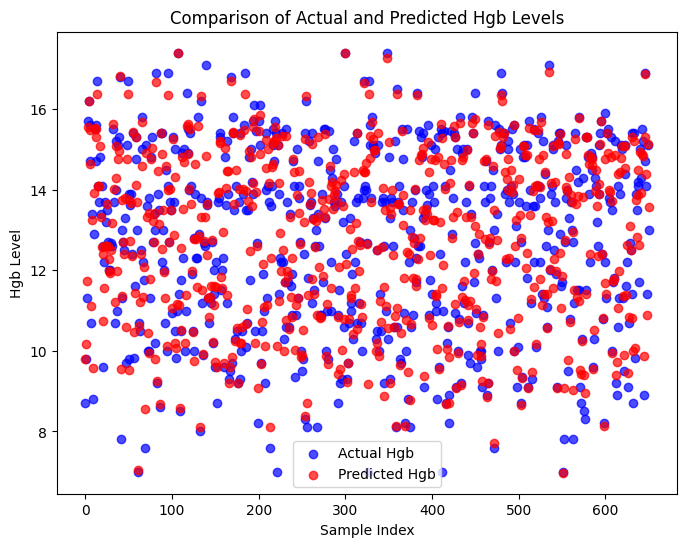

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_color_val)), y_color_val, color='blue', label='Actual Hgb', alpha=0.7)
plt.scatter(range(len(final_predictions_val)), final_predictions_val, color='red', label='Predicted Hgb', alpha=0.7)
plt.title("Comparison of Actual and Predicted Hgb Levels")
plt.xlabel("Sample Index")
plt.ylabel("Hgb Level")
plt.legend()
plt.show()
